In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.datasets import make_classification

from catboost import CatBoostClassifier

import hyperopt

import shap

## Shap смотрим, построенный на модели CatBoost

In [2]:
## !pip install shap

#### 1. Просто строим рандомную классификацию

In [3]:
f = 30                                          # кол-во фичей

X, y = make_classification(n_samples=5_000,     # строк
                           n_features= f, 
                           n_informative=5,     # что-то типа количества информативных фичей (имеющих разделяющую способность)
                           weights=[0.7, 0.3],  # дисбаланс классов 
                           random_state=42)  

In [4]:
df = pd.concat( [ pd.DataFrame( X, columns=['col_'+str(i) for i in range(f)] ), pd.Series(y).rename('target') ], axis=1 )

for col in [i for i in df.columns if 'col' in i]:
    df[col] = df[col] * pd.Series([random.random() for num in range(len(df))]).rename('random')             # умножаем на рандом

In [5]:
df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,target
0,-0.973152,0.384596,-0.427117,0.181852,-0.044755,-0.257189,-0.020728,0.394743,0.526230,1.932571,...,0.448960,-1.450170,-0.426070,-0.243751,0.395713,0.778981,-0.186188,-0.576405,-0.137972,1
1,0.125372,-0.054934,2.316050,0.540012,-0.549699,0.862160,-0.736192,1.102031,-0.147019,0.445206,...,0.517778,-0.120428,-0.148396,-0.433556,0.028024,0.221759,1.458214,0.057956,0.450355,0
2,0.203619,-0.175187,-0.084216,-0.093123,-1.662946,-0.686000,-0.400268,0.596630,0.269127,0.266472,...,-2.099232,-1.415433,0.079330,0.442658,1.022763,-0.674146,0.999120,2.501602,-0.396849,0
3,-0.135510,0.743617,0.260369,0.035268,0.134331,0.002971,-0.531672,-1.186410,-0.147530,-0.089221,...,-0.022665,-0.069245,0.375717,0.027992,0.169017,0.334726,0.569417,0.381621,1.366049,0
4,1.145244,0.174395,0.062799,-0.077267,0.365214,0.059870,-1.511479,0.199656,-0.472692,-0.002296,...,-0.196874,-1.212832,-0.095509,-0.985641,1.104588,-0.272910,4.511058,0.026903,-0.476123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.159439,-0.252378,0.276038,-0.109294,0.216353,-0.098449,-0.462420,-0.881625,0.634213,0.577572,...,-2.273402,-0.749825,0.000682,0.490136,0.276797,0.386680,0.449280,-0.021318,-0.388357,0
4996,0.430183,0.022133,-0.167547,-0.153336,-0.183023,-0.227803,-0.593896,0.519156,-0.564130,0.076753,...,1.144075,0.312090,-0.380166,0.075720,0.513937,0.900577,0.484905,-0.477488,-0.019783,0
4997,0.716573,-0.183468,0.752581,0.075626,0.281052,1.348867,-1.047617,0.033812,-1.314307,0.205487,...,1.209703,0.374779,0.762182,0.125019,-0.017661,-0.161001,1.241058,0.842363,-0.038810,0
4998,-0.282815,0.160241,0.479266,-0.184592,0.219777,-0.583898,-0.028494,0.463827,1.032964,0.046472,...,-0.578075,-0.448819,0.171916,0.035590,0.259190,1.336241,-0.454435,-0.121174,0.274710,1


#### Обучение

In [6]:
X = df.drop('target', axis=1)
y = df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [8]:
# custom_loss будет задавать какие скоры мы увидим в get_best_score()

model = CatBoostClassifier(random_state=9, custom_loss=['AUC', 'Accuracy'])

model.fit(X = X_train, 
          y = y_train, 
          eval_set=(X_test, y_test), 
          verbose=False) 

In [9]:
model.get_best_score()

{'learn': {'Accuracy': 0.9997142857142857, 'Logloss': 0.026616005686333363},
 'validation': {'Accuracy': 0.892,
  'Logloss': 0.2739931691760202,
  'AUC': 0.9440591237878115}}

In [10]:
model.get_best_score()['validation']['AUC']

0.9440591237878115

In [11]:
# у нас есть модель model

#### 1. Shap summary_plot (beeswarm)

In [12]:
                                                         # когда уже есть обученная модель
explainer = shap.TreeExplainer(model)                    # создаем объект, отвечающий за визуализацию

In [13]:
# ЭТО САМЫЙ ВАЖНЫЙ ПАРАМЕТР, ОТ НЕГО ВСЕ ФОРМИРУЕТСЯ

                                                         # выбираем датасет например весь df, X_train, X_test, мб какая-то валидация
shap_values = explainer.shap_values(X_test)              # калькулируем значения shap на ОПРЕДЕЛЕННОМ ДАТАСЕТЕ!!! это именно то, что мы и будем строить

#####  
##### shap_values это по сути массив значений отклонений по предикту (выраженный не в вероятностях), которые дает каждая фича для каждой записи (каждого предикта) в датасете  
##### 

In [14]:
shap_values

array([[-4.21607589e-01, -1.56703157e-04, -2.68068152e-02, ...,
        -6.08597788e-01, -1.72220170e-02,  2.37376529e-03],
       [-4.20314777e-01,  8.73411926e-03,  1.57538868e-02, ...,
        -2.91093016e-01, -1.13278480e-02, -6.93707846e-03],
       [-3.39976198e-01,  3.31101733e-03, -8.12827910e-03, ...,
         1.15611375e+00,  4.61260898e-03,  5.57925484e-02],
       ...,
       [ 5.75898134e-02,  7.13715067e-03, -1.56984110e-02, ...,
         1.07476584e+00,  2.84465652e-02,  7.12754037e-02],
       [-1.47970207e-01, -3.14477218e-04, -1.67476258e-02, ...,
         1.15790873e-01, -2.74038160e-02, -8.99171268e-02],
       [ 1.62486684e+00, -1.10550015e-02,  3.98689546e-02, ...,
         7.94174929e-01,  1.70060966e-02,  1.26668731e-01]])

In [15]:
# массив shap_values имеет ту же размерность, что и датасет, на котором он строится

shap_values.shape

(1500, 30)

In [16]:
X_test.shape

(1500, 30)

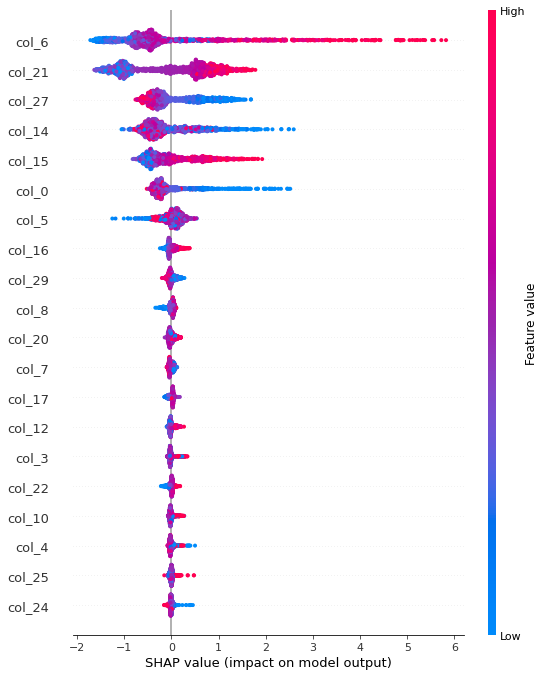

In [17]:
# Для построения summary plot нужна матрица.
# Видимо, для разных моделей по-разному, иногда пишут использовать shap_values[index] !!!
# Пишут так же, что с xgboost будет работать быстрее, есть для него какая-то оптимизация

# скорее всего для других моделей она будет называться shap.plots.beeswarm

shap.summary_plot(shap_values, X_test, max_display=20)             # верхняя фича имеет максимальное среднее абсолютное внесенное в предикт отклонение среди прочих фичей
                                                                   # хотя отдельные записи могут вываливаться левее и правее в фичах расположенных ниже по shap

In [18]:
# можно построить этот же график в абсолюте 

# shap.summary_plot(np.abs(shap_values), X_test, max_display=20)

In [19]:
# каждая строка на графике summary_plot это столбец массива shap_values

# например, ищем конкретную колонку для текущего примера

In [20]:
# колонка 6

# X_test.iloc[:, 6]

In [21]:
X_test.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21',
       'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28',
       'col_29'],
      dtype='object')

#### мы можем каждое значение из графика найти в матрице shap_values, а значит и в датасете

In [22]:
# смотрим и проверяем на графике выше

col_ind = 6 

print(f'''Длина колонки                   № {col_ind} = {len(shap_values[:, col_ind])} значений отклонения''')
print(f'''Минимальное отклонение по фиче  № {col_ind} = {np.min(shap_values[:, col_ind])} значений отклонения''')
print(f'''Максимальное отклонение по фиче № {col_ind} = {np.max(shap_values[:, col_ind])} значений отклонения''')

Длина колонки                   № 6 = 1500 значений отклонения
Минимальное отклонение по фиче  № 6 = -1.7151460723456355 значений отклонения
Максимальное отклонение по фиче № 6 = 5.820634977273326 значений отклонения


In [23]:
shap_values[:, col_ind]

array([-1.36548585, -0.75161665, -0.4554821 , ..., -0.13875981,
       -0.23851706,  2.17270149])

In [24]:
# model.predict_proba(X_test[model.feature_names_])

In [25]:
# первая фича         - shap_values[:, 0]

# первая стрка/запись - shap_values[0]

In [26]:
# Поскольку фича дает как отрицательные так и положительные отклонения - мы считаем среднее отклонение от модуля всех отклонений по фиче 

len(shap_values.mean(axis=0))                   # количество средних значений = количеству фичей

30

In [27]:
                                                # они идут в том же порядке, что и колонки в датасете
shap_sum = np.abs(shap_values).mean(axis=0)     # записываем средние для датасета отклонения (влияния фичи) по фиче

In [28]:
# Таким образом, приблизительно важность фичей по shap мы можем отобразить так

In [29]:
# X_test.columns.tolist()

In [30]:
# shap_sum.tolist()

In [31]:
importance_df_shap = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T

In [32]:
importance_df_shap.columns = ['feature', 'shap_importance']

In [33]:
importance_df_shap = importance_df_shap.sort_values('shap_importance', ascending=False)

In [34]:
# важность фичей с точки зрения среднего абсолютного отклонения

importance_df_shap.head()

,feature,shap_importance
6,col_6,0.991019
21,col_21,0.786294
27,col_27,0.464846
14,col_14,0.463874
15,col_15,0.437746


In [35]:
# важность фичей с точки зрения самой модели может не совпадать с shap

# по модели

importance_df_model = pd.concat( [pd.Series(model.feature_names_).rename('feature'), pd.Series(model.feature_importances_).rename('model_importance')], axis=1 )
importance_df_model = importance_df_model.sort_values('model_importance', ascending=False)

In [36]:
importance_df_model.head()

,feature,model_importance
6,col_6,22.732348
21,col_21,13.220750
14,col_14,12.871457
15,col_15,7.776144
27,col_27,7.015968


In [37]:
# Важность фичей по shap будет меняться от датасета к датасету, а важность по модели остается постоянной, возможно, по модели ориентироваться понадежнее

#### 2. Shap dependence_plot

In [38]:
# теперь для визуализации вклада каждого предиктора используем отдельный график по ней

X_test

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29
1501,1.612118,-0.000169,0.344082,-0.078041,0.411858,0.764164,-0.950469,-0.122582,0.260842,-0.339869,...,0.116933,1.799101,0.002304,-0.133017,1.575099,0.599003,0.334633,3.671110,-0.034751,-0.070432
2586,1.775680,-0.005125,-0.068787,-0.036016,1.512966,1.037594,-0.449413,0.114155,1.091833,0.068114,...,0.316517,0.411881,0.139834,0.271653,-0.801951,1.588863,0.045092,0.739243,-0.050062,-0.009009
2653,0.146335,-0.133513,0.147931,-0.131988,-0.003393,-1.862370,-0.071278,0.129539,-0.014893,0.316376,...,0.031334,0.986099,-0.221268,-0.793459,-1.478337,-0.124931,0.580806,-0.785095,0.956003,-0.308072
1055,0.010636,-0.772007,0.118980,0.781478,0.029282,0.315932,-1.103130,0.531955,-0.344600,-0.015824,...,-0.099224,-1.794938,0.437035,0.270478,0.020732,0.506183,0.151151,0.537186,0.156501,0.014289
705,-0.327147,-0.022026,-1.051305,-0.086053,-0.117381,0.267993,-0.148085,0.287205,-0.447030,-0.372036,...,0.357553,0.967921,0.063446,0.582647,0.101472,0.108300,-0.385226,0.301985,0.175201,0.797512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,-0.559288,0.022131,0.159765,-0.067948,-0.084646,-0.168237,-0.602501,0.050747,-0.298793,0.127426,...,-0.228219,1.026768,-0.488739,0.023103,-0.064665,0.134306,0.467280,0.599356,0.178748,0.121624
1538,0.220468,-1.414202,0.441513,0.089629,0.005650,-0.731741,0.041030,-0.313686,0.291449,-0.307557,...,0.367445,0.245980,-0.238791,-0.028793,-0.142933,0.054745,0.031690,0.666261,0.086653,0.031953
1837,-0.077915,0.036813,0.270653,1.505689,0.537359,-0.742449,-1.039803,0.351523,0.005916,0.008567,...,0.169379,0.197167,1.351816,0.015118,0.353984,0.094581,0.330519,-0.324327,0.078259,-0.412375
2380,1.630770,-0.288757,0.135619,1.248181,-0.534184,-0.619348,-1.110942,-0.015245,-0.090696,-0.800340,...,-0.775070,0.411784,0.603585,0.049809,-0.869104,-0.139426,0.213892,0.138393,-0.482088,0.416325


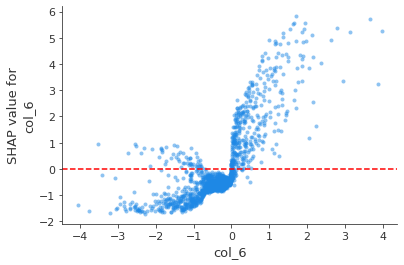

In [39]:
# у Важных фичей по Shap тут будет какой-то тренд просматриваться
# неважные должны болтаться где-то около 0 по OY

# импакт (отклоненеие) здесь по вертикали (на summary plot оно бюло по горизонтали)
# значение фичи по горизонтали

fig, ax = plt.subplots()

shap.dependence_plot('col_6', 
                     shap_values, 
                     X_test, 
                     interaction_index=None,           # col_0 покажет цветом взаимодействие с фичёй col_0;    None - без разукрашивания
                     alpha=0.5,                        # прозрачность
                     ax=ax,                            # передаем управление фигурой в матплотлиб
                     show=False,                       # не показывать сразу
                     #show=False
                     #xmin=-10,
                     #ymin=-20,
                     #xmax=10,                         # отрезает значенияпо ОX    'percentile(50)' - по медиане, например или просто значение 3
                     #ymax=10
                    )

ax.axhline(y=0, color='r', linestyle='--')
# plt.show()

#### 3.Shap force_plot - разрез для одного наблюдения

#### Что бы выбрать нужный индекс лучше сделать reset_index(drop=True), поскольку в X_train и в X_test индексы перепутаны
#### Либо как-то строго задавать индексацию, что бы индекс наблюдения в датасете и в shap_values - совпадал

In [40]:
X_test = X_test.reset_index(drop=True)          # индексацию задаем с нуля

In [41]:
# X_test

In [42]:
shap_values = explainer.shap_values(X_test)

In [43]:
X_test.shape

(1500, 30)

In [44]:
shap_values.shape

(1500, 30)

In [45]:
# можно добавить shap для отдельного клиента (наблюдения)... имеет смысл смотреть именно на НОВЫХ клиентах по которым модель уже работает

# выбрием индекс клиента (наблюдения)

observation_index = 0

observation = X_test.loc[observation_index]               # нужная строка в данных
need_cols = X_test.columns.tolist()                       # список колонок
observation_shap = shap_values[observation_index, :]      # нужная строка в значениях shap

In [46]:
len(observation)

30

In [47]:
len(need_cols)

30

In [48]:
len(observation_shap)

30

In [52]:
# Это операции обратные друг другу

def sigmoida(i):
    return 1 / (1 + np.exp(-i))

def log_odds(i):
    # i - вероятность класса 1
    return np.log(i / (1 - i))

In [78]:
log_odds(sigmoida(0.33))

0.3300000000000003

In [53]:
# базовое значение предикта, до внесения вклада фичей - это среднее предсказание модели (или среднее log-odds для классификации) на ТРЕЙНЕ

print(f'''Базовое значение предикта в логитах        = {explainer.expected_value}''')
print(f'''Базовое значение предикта в вероятностях   = {sigmoida(explainer.expected_value)}''')
print(f'''Среднее значение шансов                    = {np.mean([log_odds(j) for j in model.predict_proba(X_train)[:, 1]])}''')

Базовое значение предикта в логитах        = -1.6835454960766263
Базовое значение предикта в вероятностях   = 0.1566265573443512
Среднее значение шансов                    = -1.6835454960766254


In [54]:
# observation     # нулевая строка в данных

In [55]:
observation_shap

array([-4.21607589e-01, -1.56703157e-04, -2.68068152e-02, -3.81958437e-03,
       -1.08087524e-03, -9.72868272e-02, -1.36548585e+00,  7.25251998e-02,
        6.08605550e-02,  1.32560272e-02, -8.93719135e-03,  1.21806330e-01,
       -3.67711326e-02,  1.89685009e-02, -4.85228144e-01, -4.49756633e-01,
       -1.73158540e-02,  2.40691182e-02, -1.77656348e-03, -2.46181984e-02,
       -2.68521823e-02,  9.05582017e-01, -4.87633565e-03, -5.71642703e-03,
       -3.34243220e-02, -2.54528869e-02, -7.29694628e-04, -6.08597788e-01,
       -1.72220170e-02,  2.37376529e-03])

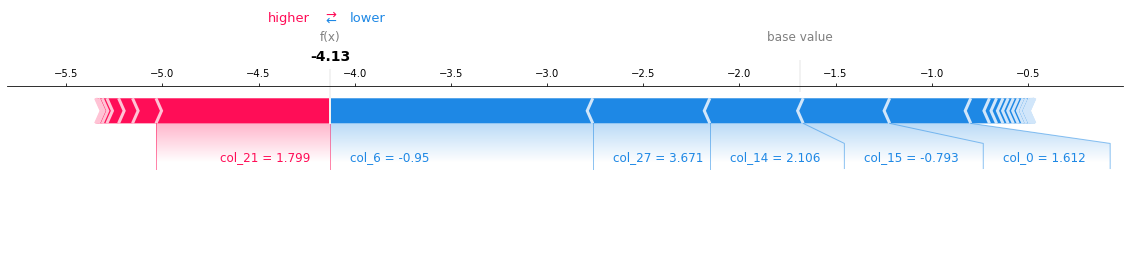

In [56]:
# Построение force_plot для одного наблюдения
shap.force_plot(
                explainer.expected_value,              # Ожидаемое значение модели (базовое значение)
                observation_shap,                      # SHAP значения для выбранного наблюдения
                round(observation, 3),                 # Данные наблюдения
                feature_names=need_cols,               # Имена признаков
                matplotlib=True,                       # Использовать matplotlib для отображения
                #show=False               
               )

#plt.text(0.5, -0.1, f'Base Value: {explainer.expected_value:.2f}', fontsize=12, ha='center')

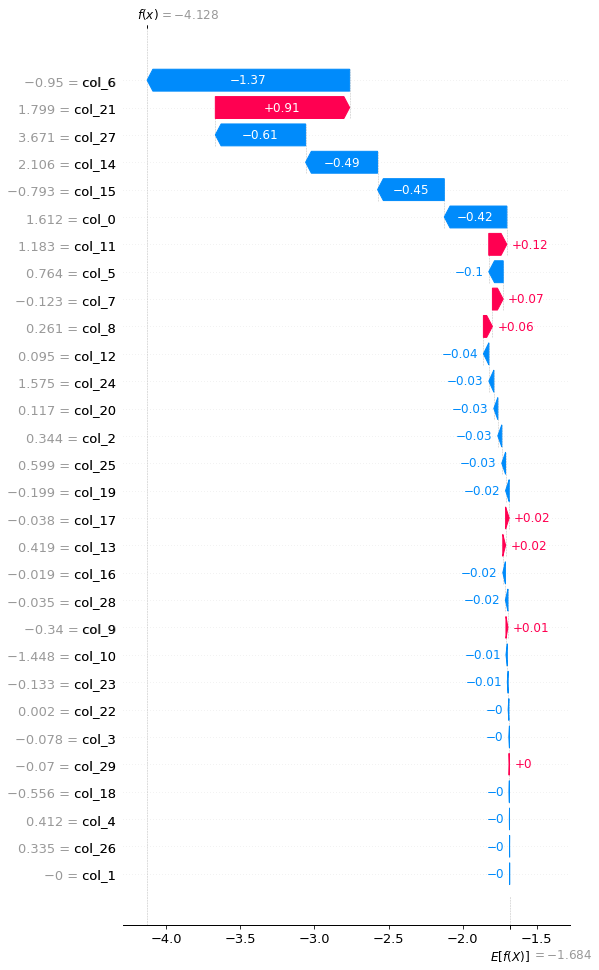

In [57]:
# изменение предсказания в пространстве логитов

shap.plots.waterfall(
                     shap.Explanation(
                                      values=observation_shap,                            # SHAP значения для наблюдения
                                      base_values=explainer.expected_value,               # Базовое значение модели
                                      data=observation,                                   # Данные наблюдения
                                      feature_names=need_cols                             # Имена признаков
                                     ), 
                     max_display=35
                    )

In [58]:
# базовое значение + вклад всех предикторов = предикт модели

print(f'''предикт в пространстве логитов      - {explainer.expected_value + np.sum(observation_shap)}''')

shap_predict = explainer.expected_value + observation_shap.sum()

print(f'''предикт в пространстве вероятностей - {1 / (1 + np.exp(-shap_predict))}''')
print(f'''предикт класса 1 по модели          - {model.predict_proba(observation)[1]}''')

предикт в пространстве логитов      - -4.127623596321328
предикт в пространстве вероятностей - 0.01586537568239003
предикт класса 1 по модели          - 0.015865375682390003


In [59]:
shap_predict

-4.127623596321328

In [60]:
# предикт по наблюдению

model.predict_proba(observation)

array([0.98413462, 0.01586538])

#### Более интуитивно-понятное отображение в вероятностях. Так лучше не делать, вклад фичи в предикт оценивается уже с учетом всех предыдущих вкладов.

In [61]:
X_test.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29
0,1.612118,-0.000169,0.344082,-0.078041,0.411858,0.764164,-0.950469,-0.122582,0.260842,-0.339869,...,0.116933,1.799101,0.002304,-0.133017,1.575099,0.599003,0.334633,3.671110,-0.034751,-0.070432
1,1.775680,-0.005125,-0.068787,-0.036016,1.512966,1.037594,-0.449413,0.114155,1.091833,0.068114,...,0.316517,0.411881,0.139834,0.271653,-0.801951,1.588863,0.045092,0.739243,-0.050062,-0.009009


In [62]:
# Выберем первое наблюдение для примера

observation_index = 0

shap_values_ind = shap_values[observation_index]

In [63]:
# Преобразуем базовое значение в вероятность

base_value_logits = explainer.expected_value

base_value_prob = 1 / (1 + np.exp(-base_value_logits))

In [64]:
print(f'''Базовое значение в логитах      = {base_value_logits}''')
print(f'''Базовое значение в вероятностях = {base_value_prob}''')

Базовое значение в логитах      = -1.6835454960766263
Базовое значение в вероятностях = 0.1566265573443512


In [65]:
# shap значения первого наблюдения

shap_values_ind

array([-4.21607589e-01, -1.56703157e-04, -2.68068152e-02, -3.81958437e-03,
       -1.08087524e-03, -9.72868272e-02, -1.36548585e+00,  7.25251998e-02,
        6.08605550e-02,  1.32560272e-02, -8.93719135e-03,  1.21806330e-01,
       -3.67711326e-02,  1.89685009e-02, -4.85228144e-01, -4.49756633e-01,
       -1.73158540e-02,  2.40691182e-02, -1.77656348e-03, -2.46181984e-02,
       -2.68521823e-02,  9.05582017e-01, -4.87633565e-03, -5.71642703e-03,
       -3.34243220e-02, -2.54528869e-02, -7.29694628e-04, -6.08597788e-01,
       -1.72220170e-02,  2.37376529e-03])

In [66]:
# для каждого значения shap считаем вероятность как сумму базового предсказания + вклад всех показателей до текущего

shap_values_ind_sum = [base_value_logits+sum(shap_values_ind[:i+1]) for i, v in enumerate(shap_values_ind)]

In [67]:
# shap_values_ind_sum

In [68]:
# вероятности для наблюдения после вклада фичей

shap_prob_contributions_sum = np.array([sigmoida(i) for i in shap_values_ind_sum]); shap_prob_contributions_sum

array([0.10859698, 0.10858181, 0.10601422, 0.10565277, 0.10555068,
       0.09671201, 0.02660244, 0.02854635, 0.03028341, 0.03067512,
       0.03041049, 0.03421494, 0.03302046, 0.03363152, 0.02097328,
       0.01347881, 0.01325048, 0.0135689 , 0.01354514, 0.01322011,
       0.01287436, 0.03125028, 0.03110299, 0.03093119, 0.02994487,
       0.02921429, 0.0291936 , 0.01609889, 0.01582836, 0.01586538])

In [69]:
# значение вклада каждого предиктора ( нужно из каждого значения вычесть (базовый предикт + сумма всех предыдущих)

shap_prob_contributions_part = []

for i, v in enumerate(shap_prob_contributions_sum):
    
    if i == 0:
        
        shap_prob_contributions_part.append(v - base_value_prob)
    else:
        shap_prob_contributions_part.append(v - shap_prob_contributions_sum[i-1])

In [70]:
shap_prob_contributions_part = np.array(shap_prob_contributions_part)

In [71]:
# значение вклада каждого предиктора

base_value_prob+sum(shap_prob_contributions_part) 

0.01586537568239002

In [72]:
model.predict_proba(X_test.loc[observation_index])[1]

0.015865375682390003

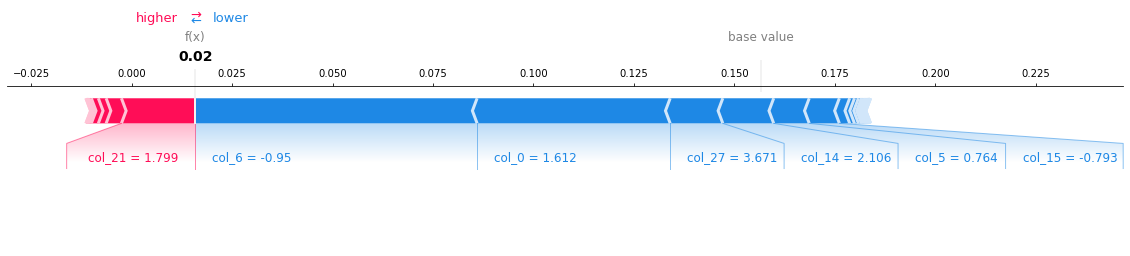

In [73]:
# Построение force_plot для одного наблюдения в пространстве вероятностей

shap.force_plot(
                base_value_prob,                       # Ожидаемое значение модели (базовое значение)
                shap_prob_contributions_part,          # SHAP значения для выбранного наблюдения приведенные в вероятности
                round(observation, 3),                 # Данные наблюдения
                feature_names=need_cols,               # Имена признаков
                matplotlib=True,                       # Использовать matplotlib для отображения
                #show=False
               )

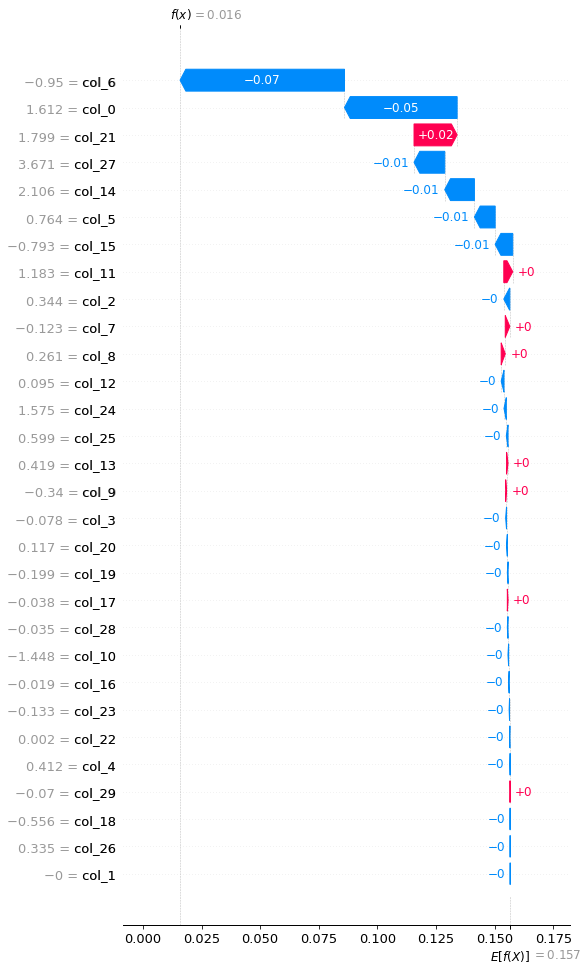

Base probability:    0.1566265573443512
Final probability:   0.01586537568239002
Model predict_proba: 0.015865375682390003


In [74]:
# Создаем waterfall plot в пространстве вероятностей

shap.plots.waterfall(
                     shap.Explanation(
                         values=shap_prob_contributions_part,                           # Shap значения переведенные в вероятности
                         base_values=base_value_prob,                                   # Базовое предсказание переведенное в вероятность
                         data=X_test.loc[observation_index],                            # Данные наблюдения
                         feature_names=X_test.columns.to_list()                         # Имена признаков
                                     ),
                     max_display=30  # Ограничиваем количество отображаемых признаков
                    )

# Выводим итоговое значение вероятности
print(f"Base probability:    {base_value_prob}")
print(f"Final probability:   {base_value_prob+sum(shap_prob_contributions_part)}")
print(f"Model predict_proba: {model.predict_proba(X_test.loc[observation_index])[1]}")

#### 3. Сущностное объяснение значений Шепли

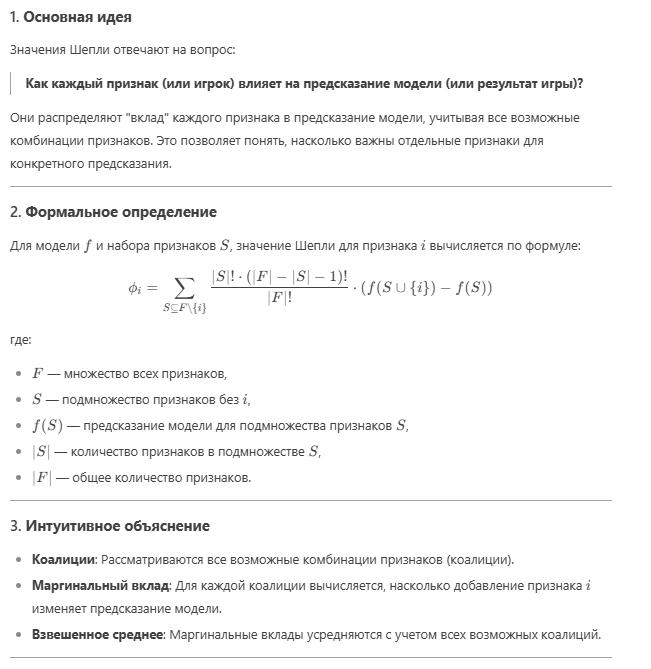

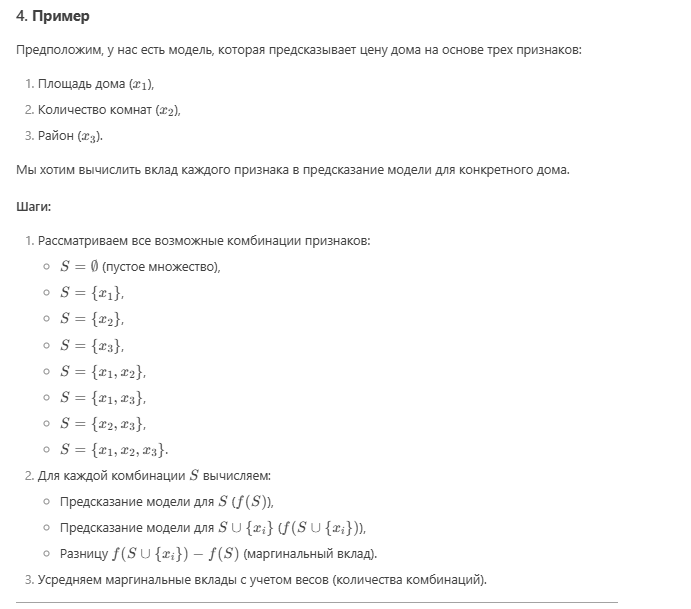

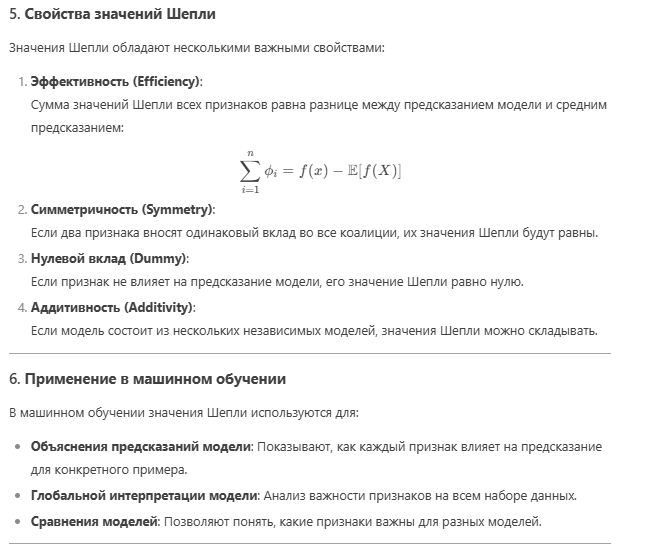

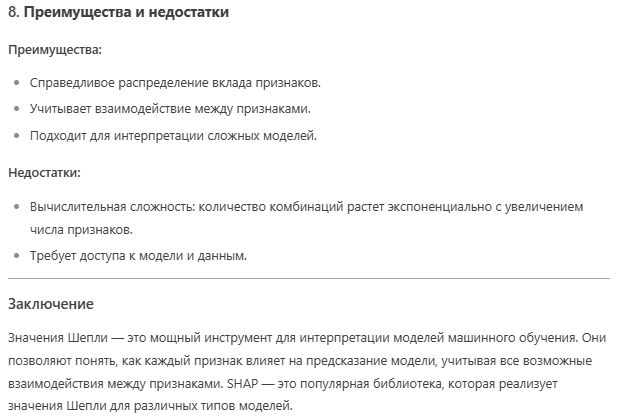